In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, log_loss, roc_auc_score, auc, roc_curve,f1_score, mutual_info_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
data = pd.read_csv('/Users/kamilla/Desktop/RecSys/HW_2/data.csv')
# уберем фичи, которые не используются для задания 
unused_features = ['oaid_hash', 'rate0', 'rate1']
data.drop(columns=unused_features, inplace=True)
data.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,banner_id0,g0,coeff_sum0,banner_id1,g1,coeff_sum1,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,0,0,0,1240,0.035016,-7.268846,0,0.049516,-5.369901,1,1
1,2021-09-26 22:54:49.000000,1,1,0,0,1,1,0.054298,-2.657477,269,0.031942,-4.449220,1,1
2,2021-09-26 23:57:20.000000,2,2,3,0,0,2,0.014096,-3.824875,21,0.014906,-3.939309,1,1
3,2021-09-27 00:04:30.000000,3,3,0,1,1,3,0.015232,-3.461357,99,0.050671,-3.418403,1,1
4,2021-09-27 00:06:21.000000,4,4,0,1,0,4,0.051265,-4.009026,11464230,0.032005,-2.828797,1,1


# I. Подготовка данных 

## Посмотрим на фичи, с которыми не работали раньше 

In [9]:
new_features = ['banner_id0', 'g0', 'coeff_sum0', 'banner_id1', 'g1', 'coeff_sum1']

In [10]:
print("Типы данных в датасете:")
data[new_features].info()
print("-----------------------------------------------")
print(data[new_features].describe())
print(f"Количество повторяющихся значений признаков: {len(data[data[new_features].duplicated()])}")
print("Количество нулевых значений признаков:", data[new_features].isna().sum(), sep='\n')
    

Типы данных в датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15821472 entries, 0 to 15821471
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   banner_id0  int64  
 1   g0          float64
 2   coeff_sum0  float64
 3   banner_id1  int64  
 4   g1          float64
 5   coeff_sum1  float64
dtypes: float64(4), int64(2)
memory usage: 724.2 MB
-----------------------------------------------
         banner_id0            g0    coeff_sum0    banner_id1            g1  \
count  1.582147e+07  1.582140e+07  1.582140e+07  1.582147e+07  1.580173e+07   
mean   6.571314e+05  7.440764e-01 -3.979590e+00  2.605069e+06  5.485722e-01   
std    2.606008e+06  1.670358e+01  1.143982e+00  5.230253e+06  1.419136e+01   
min    0.000000e+00 -1.763740e-02 -8.588970e+00  0.000000e+00 -6.983897e-02   
25%    7.300000e+01  1.643856e-02 -4.515871e+00  9.900000e+01  1.615219e-02   
50%    3.030000e+02  3.539307e-02 -3.921164e+00  4.600000e+02  3.556666e-02   
75%    7.

Выводы по новым фичам: 
1. В данных имеются nun значения - избавимся от них 
2. g0 и g1 принимают отрицательные значения - избавимся от них 
3. Избавимся от повторяющихся наблюдений
4. Удалим строки, где banner_id != banner_id0.

In [3]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    
    # Избавимся от nun значений 
    data.dropna(inplace=True)
    
    # Избавимся от отрицательных значений g0 и g1
    data = data[data['g0'] >= 0]
    data = data[data['g1'] >= 0]
    
    # Убираем дубликаты 
    data.drop_duplicates(inplace=True)
    
    # Оставим строки, где banner_id == banner_id0
    data = data[data['banner_id'] == data['banner_id0']]

    
    ## Остальное как в исправленной версии hw1
    # Убираем impressions
    data.drop(columns='impressions', inplace=True)
    # Избавимся от выброса в данных
    data.date_time = pd.to_datetime(data['date_time'])
    first_date = data['date_time'].dt.date.min()
    data = data[data['date_time'].dt.date != first_date]
    print("Убедимся, что в значениях нет выброса", data['date_time'].dt.date.unique(), 
         data['date_time'].dt.date.min(), data['date_time'].dt.date.max(), sep='\n')
    # В zone_id есть значения, которые встречаются больше 2M раз, а есть значения, которые 
    # встречаются лишь единожды. Объединим редкие значения в одно, чтобы модель не считывала эти значения 
    # как выбросы и могла лучше обощаться в будущем. Пусть этим значением будет "-1"
    threshold = 20000 
    value_counts_zone_id = data['zone_id'].value_counts()
    rare_values = value_counts_zone_id[value_counts_zone_id <= threshold].index
    data['zone_id'] = data['zone_id'].apply(lambda x: -1 if x in rare_values else x)
    # Добавим интеракции 
    data['campaign_clicks_country_id'] = data['campaign_clicks'] / data.groupby('country_id')['campaign_clicks'].transform('sum')
    data['campaign_clicks_zone_id'] = data['campaign_clicks'] / data.groupby('zone_id')['campaign_clicks'].transform('sum')

    return data

In [4]:
data = feature_engineering(data)
data.head()

Убедимся, что в значениях нет выброса
[datetime.date(2021, 9, 26) datetime.date(2021, 9, 27)
 datetime.date(2021, 9, 29) datetime.date(2021, 9, 30)
 datetime.date(2021, 9, 28) datetime.date(2021, 10, 1)
 datetime.date(2021, 10, 2)]
2021-09-26
2021-10-02


,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,banner_id0,g0,coeff_sum0,banner_id1,g1,coeff_sum1,clicks,campaign_clicks_country_id,campaign_clicks_zone_id
1,2021-09-26 22:54:49,1,1,0,0,1,1,0.054298,-2.657477,269,0.031942,-4.449220,1,0.000000,0.000000
2,2021-09-26 23:57:20,2,2,3,0,0,2,0.014096,-3.824875,21,0.014906,-3.939309,1,0.000003,0.000025
3,2021-09-27 00:04:30,3,3,0,1,1,3,0.015232,-3.461357,99,0.050671,-3.418403,1,0.000000,0.000000
4,2021-09-27 00:06:21,-1,4,0,1,0,4,0.051265,-4.009026,11464230,0.032005,-2.828797,1,0.000000,0.000000
5,2021-09-27 00:06:50,-1,5,0,2,2,5,0.337634,-3.222757,37,0.338195,-3.221755,1,0.000000,0.000000


### Добавим фичи времени, а также разделим наш датасет на тренировочную и тестовую выборки

In [5]:
#data.date_time = pd.to_datetime(data['date_time'])
data['week_day'] = data['date_time'].dt.dayofweek + 1
data['quarter_of_day'] = (data['date_time'].dt.hour // 6) + 1
data['hour_day'] = (data['date_time'].dt.hour).astype('int64')    

In [6]:
# вытащим последний день - пусть это будет тестовыми данными
the_last_day = pd.to_datetime(data['date_time']) >= pd.to_datetime('2021-10-02')
test_data = data[the_last_day]

test_data_idx = test_data.index

train_data = data.drop(index=test_data_idx)

print(f"Кол-во тестовых данных: {len(test_data)}")
print(f"Кол-во тренировочных данных: {len(train_data)}")

Кол-во тестовых данных: 1883622
Кол-во тренировочных данных: 12026114


### Подставим в дополнительной тестовой выборке вместо banner_id значение banner_id1 и выделим таргеты

In [7]:
train_data.columns

Index(['date_time', 'zone_id', 'banner_id', 'campaign_clicks', 'os_id',
       'country_id', 'banner_id0', 'g0', 'coeff_sum0', 'banner_id1', 'g1',
       'coeff_sum1', 'clicks', 'campaign_clicks_country_id',
       'campaign_clicks_zone_id', 'week_day', 'quarter_of_day', 'hour_day'],
      dtype='object')

In [8]:
# фичи, которые не используются в предсказании 
unused_pred = ['clicks', 'date_time', 'coeff_sum0', 'coeff_sum1', 'g0', 'g1', 'banner_id0', 'banner_id1']

In [9]:
X_train, y_train = train_data.drop(columns=unused_pred), train_data['clicks']
X_test, y_test = test_data.drop(columns=unused_pred), test_data['clicks']

test_data_copy = test_data.copy()
test_data_copy['banner_id'] = test_data['banner_id1']
X_test_banner_id_1 = test_data_copy.drop(columns=unused_pred)



### Применим модель из отредактированной первой домашней работы 

In [10]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

In [17]:
# Из обновленной первой домашней работы: Best parameters: {'classifier__C': 0.01}

def create_model(data):
    # На этот раз будем использовать все категориальные фичи для OneHotEncoder() 
    categorical_features = ['zone_id', 'banner_id', 'os_id', 'country_id', 'week_day', 
                            'quarter_of_day', 'hour_day']

    preprocessor = ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ],
        remainder='passthrough'
    )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=10000, random_state=42, solver='liblinear', C=0.01,
                                           penalty='l2', fit_intercept=False, verbose=2))
    ])

    pipeline.fit(X_train, y_train)

    # Validation
    y_pred_test = pipeline.predict(X_test)
    y_prob_test = pipeline.predict_proba(X_test)[:, 1]

    accuracy_test = accuracy_score(y_test, y_pred_test)
    logloss_test = log_loss(y_test, y_prob_test)
    roc_auc_test = roc_auc_score(y_test, y_prob_test)

    print(f"Test Accuracy: {accuracy_test:.4f}")
    print(f"Test Log Loss: {logloss_test:.4f}")
    print(f"Test ROC AUC: {roc_auc_test:.4f}")
    print("Test Classification Report:\n", classification_report(y_test, y_pred_test))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob_test)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    return pipeline


[LibLinear]iter  1 act 5.978e+04 pre 5.297e+04 delta 2.200e+00 f 8.336e+04 |g| 6.726e+04 CG   2
iter  2 act 8.008e+03 pre 6.615e+03 delta 2.200e+00 f 2.357e+04 |g| 1.586e+04 CG   2
iter  3 act 2.037e+03 pre 1.683e+03 delta 2.200e+00 f 1.557e+04 |g| 4.974e+03 CG   3
cg reaches trust region boundary
iter  4 act 7.020e+02 pre 6.156e+02 delta 2.647e+00 f 1.353e+04 |g| 1.478e+03 CG   5
cg reaches trust region boundary
iter  5 act 2.448e+02 pre 2.252e+02 delta 3.056e+00 f 1.283e+04 |g| 5.528e+02 CG   5
cg reaches trust region boundary
iter  6 act 1.237e+02 pre 1.210e+02 delta 3.222e+00 f 1.258e+04 |g| 2.338e+02 CG   7
cg reaches trust region boundary
iter  7 act 7.157e+01 pre 6.853e+01 delta 3.388e+00 f 1.246e+04 |g| 1.413e+02 CG  11
iter  8 act 2.591e+01 pre 2.546e+01 delta 3.388e+00 f 1.239e+04 |g| 8.139e+01 CG  21
iter  9 act 1.838e+00 pre 1.830e+00 delta 3.388e+00 f 1.236e+04 |g| 2.219e+01 CG  28
iter 10 act 6.036e-02 pre 6.035e-02 delta 3.388e+00 f 1.236e+04 |g| 2.109e+00 CG  38
iter 11

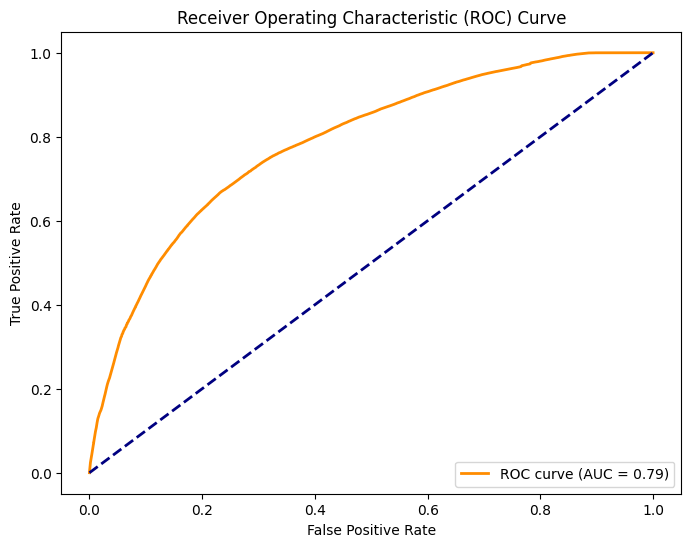

In [18]:
model = create_model(data)

### CIPS

Чтобы узнать вероятность показа баннера, нам нужно оценить вероятность того, что одна нормальная величина больше другой.

P(X_0 > X_1) = P(X_0 - X_1 > 0) = 1 - F_{X_0 - X_1}(0)

Мы знаем, что X_0 и X_1 -- независимые нормальные случайные величины

Так как X_0 и X_1 -- независимые нормальные случайные величины, то их разность -- это тоже нормальная случайная со следующими параметрами:
1. $\mu_{difference}$ = $\mu_{X_0} - \mu_{X_1}$
2. $\sigma_{difference}$ = $\sqrt{\sigma_{X_0}^2 + \sigma_{X_1}^2}$



In [25]:
from scipy.stats import norm

def calculate_policy(coefficient_0, g_value_0, coefficient_1, g_value_1):
    return 1 - norm.cdf(0, loc=coefficient_0 - coefficient_1, scale=np.sqrt(g_value_0 ** 2 + g_value_1 ** 2) + 1e-6)

pi_0 = calculate_policy(test_data_copy['coeff_sum0'], test_data_copy['g0'], test_data_copy['coeff_sum1'], test_data_copy['g1'])


In [26]:
from scipy.special import logit

test_data_copy['coeff_sum0_new'] = logit(model.predict_proba(X_test)[:, 1])
test_data_copy['coeff_sum1_new'] = logit(model.predict_proba(X_test_banner_id_1)[:, 1])

pi_1 = calculate_policy(test_data_copy['coeff_sum0_new'], test_data_copy['g0'], test_data_copy['coeff_sum1_new'], test_data_copy['g1'])


In [28]:
cips = np.mean(y_test * np.minimum(pi_1 / (pi_0 + 1e-10), 10))
print("Итоговый CIPS:", cips)

Итоговый CIPS: 0.0684007507662958
